#### IMPORTs & HELPER FUNCTIONs

In [1]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
# from qumcmc.energy_models import IsingEnergyFunction
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling

from qumcmc.classical_mcmc_routines import classical_mcmc
#from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc     #for Qulacs Simulator backend (** Faster )
from qumcmc.quantum_mcmc_routines_qulacs_exact import quantum_mcmc_exact
#  from qumcmc.quantum_mcmc_routines_qiskit import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 

from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation, get_trajectory_statistics
from scipy.linalg import expm
from qulacs.gate import DenseMatrix, SparseMatrix
from qulacs import QuantumState
from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc
from qumcmc.quantum_mcmc_qulacs_2 import quantum_enhanced_mcmc_2
from qumcmc.quantum_mcmc_routines_qulacs_exact import quantum_mcmc_exact
import pickle

### BAS dataset energy model
### class to generate BAS dataset of arbitrary gridsize.
from itertools import permutations, product
class bas_dataset:
    def __init__(self, grid_size:int):
        self.grid_size=grid_size
        all_combn=[''.join(p) for p in product('01',repeat=self.grid_size)]
        all_combn.sort(key=lambda s: s.count('1'))
        all_combn.pop(0);all_combn.pop(-1)
        self.__all_combn=all_combn
        self.bas_dict=self.bars_and_stripes_dataset()
        self.dataset=self.bas_dict['stripes']+self.bas_dict['bars']
    
    def vertical_stripes(self):
        vert_stripes=[j*self.grid_size for j in self.__all_combn]
        return vert_stripes

    def horizontal_bars(self):
        hor_bars=[]
        for l in self.__all_combn:
            st=""
            for j in l:
                st=st+j*self.grid_size
            hor_bars.append(st)
        return hor_bars

    def bars_and_stripes_dataset(self):
        bas_dict={'stripes':self.vertical_stripes(),
            'bars':self.horizontal_bars()}
        return bas_dict

    ### create matrix of bitstring: meant for plotting
    def bit_string_to_2d_matrix(self,bitstring, array_shape:int):
        len_bs=len(bitstring)
        list_bs_int=[eval(i) for i in list(bitstring)]
        arr_bs=np.reshape(list_bs_int,(array_shape, array_shape))
        return arr_bs

    ### plot pixels
    def draw_pixelplot(self,bitstring:str,array_shape:int):
        im_array=self.bit_string_to_2d_matrix(bitstring,array_shape)
        plt.title(f"pixel plot for bitstring: {bitstring}")
        pixel_plot=plt.imshow(im_array,cmap='Greens',interpolation='nearest')
        plt.colorbar(pixel_plot)
        plt.show()
# hebbing learning
def hebbing_learning(list_bas_state:list):
    size=len(list_bas_state[0])
    wts=0
    for i in list_bas_state:
        arr=np.array([-1 if elem == "0" else 1 for elem in i])
        array=np.reshape(arr,(size,1));array_t=np.transpose(array)
        wts+=array@array_t
    wts=wts-len(list_bas_state)*np.identity(size)
    return wts
def define_random_spin_ising_model(n_spins:int,seed_val:int):
    # define the model # seed 4
    np.random.seed(seed_val)#(610358)# should always be in the same cell!  ## best seed -> 610358

    ## construct problem Hamiltonian ##
    shape_of_J=(n_spins,n_spins)

    ## defining J matrix (mutual 1-1 interaction)
    J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
    J =  np.random.uniform(low= -2, high= 2, size= shape_of_J )
    J = 0.5 * (J + J.transpose() )
    J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

    # defining h
    h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)
    # instantiate the model
    model = IsingEnergyFunction(J, h, name= 'my_model')
    return model

#### EXPERIMENTs

### Generate Instance

In [2]:
# 
gridsize=3
bas=bas_dataset(grid_size=gridsize)
bas.dataset.sort()
# considering only stripes dataset
wt=hebbing_learning(bas.bas_dict['bars'])

# creating ising model for the bas stripes only dataset
n_spins=gridsize*gridsize
shape_of_J=(n_spins,n_spins)
J=-1*wt
h=np.zeros(n_spins)
model=IsingEnergyFunction(J,h,name=f'ising model BAS {n_spins}X{n_spins} bars only')
#model.model_summary()

     MODEL : ising model BAS 9X9 bars only |  beta : 1.5
Num Most Probable States : 6
Entropy : 2.5849625007211547
---------------------------------------------


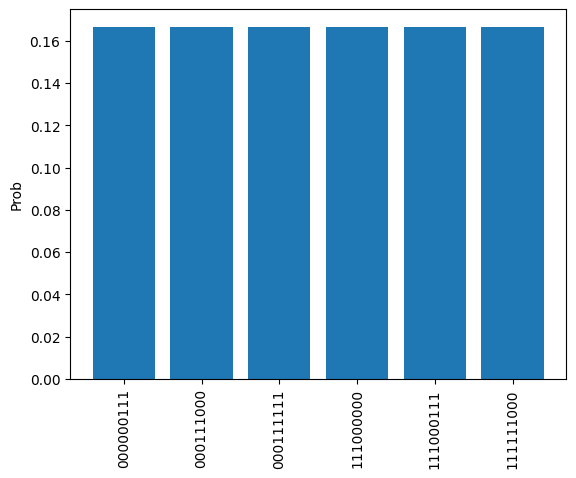

In [3]:
beta=1.5
## run exact sampling over all possible configurations 
exact_sampled_model = Exact_Sampling(model, beta)

## get distribution from the model
bpd=exact_sampled_model.boltzmann_pd
exact_sampled_model.sampling_summary()

### Run MCMC Chains

In [4]:
num_different_chains=10

#### Previous Runs @neel

In [16]:
seed_val_list=list(range(1,num_different_chains+1))
list_labels_bas=['cl','local','Q-MCMC:pauli_wt_1','Q-MCMC:pauli_wt_3']

In [17]:
init_val_keys=dict(zip(list_labels_bas,[0,0,0,0]))
list_init_val_keys=[init_val_keys.copy() for i in range(1,num_different_chains+1)]
dict_mcmc_bas_gridsize_3=dict(zip(seed_val_list,list_init_val_keys))
print(dict_mcmc_bas_gridsize_3)

{1: {'cl': 0, 'local': 0, 'Q-MCMC:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_3': 0}, 2: {'cl': 0, 'local': 0, 'Q-MCMC:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_3': 0}, 3: {'cl': 0, 'local': 0, 'Q-MCMC:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_3': 0}, 4: {'cl': 0, 'local': 0, 'Q-MCMC:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_3': 0}, 5: {'cl': 0, 'local': 0, 'Q-MCMC:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_3': 0}, 6: {'cl': 0, 'local': 0, 'Q-MCMC:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_3': 0}, 7: {'cl': 0, 'local': 0, 'Q-MCMC:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_3': 0}, 8: {'cl': 0, 'local': 0, 'Q-MCMC:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_3': 0}, 9: {'cl': 0, 'local': 0, 'Q-MCMC:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_3': 0}, 10: {'cl': 0, 'local': 0, 'Q-MCMC:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_3': 0}}


In [75]:
### case of mismatched hamiltonian
import random
n_spins=10
model=define_random_spin_ising_model(n_spins=n_spins,seed_val=1)# data for presentation.
beta=1.5
## run exact sampling over all possible configurations 
exact_sampled_model = Exact_Sampling(model, beta)

## get distribution from the model
bpd=exact_sampled_model.boltzmann_pd
#exact_sampled_model.sampling_summary()


random_indices=random.sample(range(0,7),k=5)
J_pert=model.get_J
for j in random_indices:
    J_pert[j,j+1]=-1*J_pert[j,j+1]
h_pert=model.get_h
model_pert=IsingEnergyFunction(J_pert,h_pert,name=f'perturbed {n_spins}X{n_spins}')

# run mcmc for perturbed case
num_different_chains=10
seed_val_list=list(range(1,num_different_chains+1))
list_labels_bas=['Q-MCMC perturbed:pauli_wt_1']
init_val_keys=dict(zip(list_labels_bas,[0]))
list_init_val_keys=[init_val_keys.copy() for i in range(1,num_different_chains+1)]
dict_perturbed=dict(zip(seed_val_list,list_init_val_keys))

# quantum 1: single qubit pauli
for seed_val in range(1,num_different_chains+1):
    steps = 15000
    #list_labels.append('QMCMC; pauli_wt-1; gamma range=(0.2,0.6)')
    qamcmc_chain_1 =quantum_enhanced_mcmc_2(
        n_hops=steps,
        model=model_pert,
        temperature=1/beta,
        verbose=True,
        name= 'Q-MCMC perturbed:pauli_wt_1',
        gamma_range=(0.1,0.4)
    )
    #qumcm1_statistic = get_trajectory_statistics(qamcmc_chain_1, exact_sampled_model, verbose= False)
    dict_perturbed[seed_val]['Q-MCMC perturbed:pauli_wt_1']=qamcmc_chain_1





runnning quantum MCMC steps . ..:   0%|          | 5/15000 [00:00<05:53, 42.39it/s]

starting with:  0111010001 with energy: 0.051000000000000156


runnning quantum MCMC steps . ..:   0%|          | 10/15000 [00:00<02:40, 93.69it/s]

starting with:  1001000110 with energy: -0.4249999999999998


runnning quantum MCMC steps . ..:   0%|          | 5/15000 [00:00<05:20, 46.72it/s]

starting with:  1010111000 with energy: -2.4669999999999996


runnning quantum MCMC steps . ..:   0%|          | 7/15000 [00:00<04:38, 53.87it/s]

starting with:  0001100111 with energy: -1.239


runnning quantum MCMC steps . ..:   0%|          | 2/15000 [00:00<12:47, 19.53it/s]

starting with:  1011100001 with energy: -4.569000000000001


runnning quantum MCMC steps . ..:   0%|          | 10/15000 [00:00<02:40, 93.68it/s]

starting with:  1001110101 with energy: -3.809


runnning quantum MCMC steps . ..:   0%|          | 10/15000 [00:00<02:56, 84.96it/s]

starting with:  1110111100 with energy: -4.7490000000000006


runnning quantum MCMC steps . ..:   0%|          | 9/15000 [00:00<03:08, 79.64it/s]

starting with:  0001010011 with energy: -1.782999999999999


runnning quantum MCMC steps . ..:   0%|          | 8/15000 [00:00<03:21, 74.49it/s]

starting with:  1000001001 with energy: -10.375


runnning quantum MCMC steps . ..:   0%|          | 5/15000 [00:00<05:10, 48.23it/s]

starting with:  0001010001 with energy: 0.9910000000000003


runnning quantum MCMC steps . ..: 100%|██████████| 15000/15000 [03:05<00:00, 80.95it/s] 


In [83]:
print(dict_perturbed)

{1: {'Q-MCMC perturbed:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_1': MCMCChain()}, 2: {'Q-MCMC perturbed:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_1': MCMCChain()}, 3: {'Q-MCMC perturbed:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_1': MCMCChain()}, 4: {'Q-MCMC perturbed:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_1': MCMCChain()}, 5: {'Q-MCMC perturbed:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_1': MCMCChain()}, 6: {'Q-MCMC perturbed:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_1': MCMCChain()}, 7: {'Q-MCMC perturbed:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_1': MCMCChain()}, 8: {'Q-MCMC perturbed:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_1': MCMCChain()}, 9: {'Q-MCMC perturbed:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_1': MCMCChain()}, 10: {'Q-MCMC perturbed:pauli_wt_1': 0, 'Q-MCMC:pauli_wt_1': MCMCChain()}}


In [8]:
name='dict_ising_model_num_spins_10_beta_1.5_seed_1_with_pert.pkl'
with open(name,'rb') as f:
    dict_mcmc_bas_gridsize_3=pickle.load(f)
print(dict_mcmc_bas_gridsize_3)

{1: {'cl': MCMCChain(), 'local': MCMCChain(), 'Q-MCMC': MCMCChain(), 'Q-MCMC-pert': MCMCChain()}, 2: {'cl': MCMCChain(), 'local': MCMCChain(), 'Q-MCMC': MCMCChain(), 'Q-MCMC-pert': MCMCChain()}, 3: {'cl': MCMCChain(), 'local': MCMCChain(), 'Q-MCMC': MCMCChain(), 'Q-MCMC-pert': MCMCChain()}, 4: {'cl': MCMCChain(), 'local': MCMCChain(), 'Q-MCMC': MCMCChain(), 'Q-MCMC-pert': MCMCChain()}, 5: {'cl': MCMCChain(), 'local': MCMCChain(), 'Q-MCMC': MCMCChain(), 'Q-MCMC-pert': MCMCChain()}, 6: {'cl': MCMCChain(), 'local': MCMCChain(), 'Q-MCMC': MCMCChain(), 'Q-MCMC-pert': MCMCChain()}, 7: {'cl': MCMCChain(), 'local': MCMCChain(), 'Q-MCMC': MCMCChain(), 'Q-MCMC-pert': MCMCChain()}, 8: {'cl': MCMCChain(), 'local': MCMCChain(), 'Q-MCMC': MCMCChain(), 'Q-MCMC-pert': MCMCChain()}, 9: {'cl': MCMCChain(), 'local': MCMCChain(), 'Q-MCMC': MCMCChain(), 'Q-MCMC-pert': MCMCChain()}, 10: {'cl': MCMCChain(), 'local': MCMCChain(), 'Q-MCMC': MCMCChain(), 'Q-MCMC-pert': MCMCChain()}}


In [82]:
# for i in range(1,11):
#     dict_mcmc_bas_gridsize_3[i]['Q-MCMC-pert']=dict_perturbed[i]['Q-MCMC:pauli_wt_1']

# dict_mcmc_bas_gridsize_3
# done

In [13]:
# list_labels=['cl',
#                 'QMCMC; pauli_wt-1; gamma range=(0.1,0.4)',
#                 'QMCMC; pauli_wt-2; gamma range=(0.1,0.4)','local']

In [12]:
for seed_val in range(1,num_different_chains+1):
    # classical uniform
    steps=15000
    #list_labels.append('classical uniform strategy')
    cl_chain =classical_mcmc(
        n_hops=steps,
        model=model,
        temperature=1/beta
    )
    cl_statistic = get_trajectory_statistics(cl_chain, exact_sampled_model, verbose= False)
    dict_mcmc_bas_gridsize_3[seed_val]['cl']=cl_chain

In [45]:
for seed_val in range(1,num_different_chains+1):
    # classical local
    steps=15000
    #list_labels.append('classical uniform strategy')
    cl_chain =classical_mcmc(
        n_hops=steps,
        model=model,
        temperature=1/beta,
        method='local'
    )
    cl_statistic = get_trajectory_statistics(cl_chain, exact_sampled_model, verbose= False)
    dict_mcmc_bas_gridsize_3[seed_val]['local']=cl_chain

In [ ]:
# quantum 1: single qubit pauli
for seed_val in range(1,num_different_chains+1):
    steps = 15000
    #list_labels.append('QMCMC; pauli_wt-1; gamma range=(0.2,0.6)')
    qamcmc_chain_1 =quantum_enhanced_mcmc_2(
        n_hops=steps,
        model=model,
        temperature=1/beta,
        verbose=True,
        name= 'Q-MCMC:pauli_wt_1',
        gamma_range=(0.1,0.4)
    )
    qumcm1_statistic = get_trajectory_statistics(qamcmc_chain_1, exact_sampled_model, verbose= False)
    dict_mcmc_bas_gridsize_3[seed_val]['Q-MCMC:pauli_wt_1']=qamcmc_chain_1

In [ ]:
for seed_val in range(1,num_different_chains+1):
# quantum 2: 
    steps = 15000
    #list_labels.append('QMCMC; pauli_wt-2; gamma range=(0.2,0.6)')
    qamcmc_chain_2 =quantum_enhanced_mcmc_2(
        n_hops=steps,
        model=model,
        temperature=1/beta,
        verbose=True,
        pauli_weight_x_mixer=3,
        name='Q-MCMC:pauli_wt_3',
        gamma_range=(0.1,0.4)
    )
    dict_mcmc_bas_gridsize_3[seed_val]['Q-MCMC:pauli_wt_3']=qamcmc_chain_2
    qumcm2_statistic = get_trajectory_statistics(qamcmc_chain_2, exact_sampled_model, verbose= False)

#### New Runs

In [13]:
## classical-local-wt3
for seed_val in tqdm(range(1,num_different_chains+1)):

    steps=15000
    #list_labels.append('classical uniform strategy')
    cl_chain =classical_mcmc(
        n_hops=steps,
        model=model,
        temperature=1/beta,
        method='local',
        num_flips= 3
    )
    cl_statistic = get_trajectory_statistics(cl_chain, exact_sampled_model, verbose= False)
    dict_mcmc_bas_gridsize_3[seed_val]['local_wt_3']=cl_chain

100%|██████████| 10/10 [1:36:10<00:00, 577.00s/it]


In [53]:
from qumcmc.basic_utils import xor_strings

In [45]:
# name=f'''dict_simulations_BAS_bars_dataset_3x3.pkl'''
# with open(name,'wb') as f:
#         pickle.dump(dict_mcmc_bas_gridsize_3,f)

# for i, data in dict_mcmc_bas_gridsize_3.items():
#     print(i)
#     keys = list(data.keys())
#     for type in keys:
#         print(type)
#         print(name_replacement[type])
#         data[name_replacement[type]] = data.pop(type)
        
# name_replacement = {'cl': 'cl-uniform', 'local': 'cl-local-wt1', 'Q-MCMC:pauli_wt_1': 'qu-wt1', 'Q-MCMC:pauli_wt_3': 'qu-wt3', 'local_wt_3': 'cl-local-wt3'}

# i = 1
# chain = SAMPLINGDATA_BAS3[1]['cl-local-wt1'].accepted_states
# xor_strings(chain[i],chain[i+1])

### Data Plottings

In [12]:
name=f'''SAMPLINGDATA_BAS3.pkl'''
with open(name,'rb') as f:
        SAMPLINGDATA_BAS3 = pickle.load(f)
    

In [7]:
# this function would be useful for plotting curves
def plot_with_error_band(xval:list,y_list_of_list:list,label:str,
                            std_dev_multiplicative_factor:int=1,
                            alpha_for_plot:float=0.5):
# for i, data in dict_mcmc_bas_gridsize_3.items():
#     print(i)
#     keys = list(data.keys())
#     for type in keys:
#         print(type)
#         print(name_replacement[type])
#         data[name_replacement[type]] = data.pop(type)
        
# name_replacement = {'cl': 'cl-uniform', 'local': 'cl-local-wt1', 'Q-MCMC:pauli_wt_1': 'qu-wt1', 'Q-MCMC:pauli_wt_3': 'qu-wt3', 'local_wt_3': 'cl-local-wt3'}
    curve_of_mean_value=np.mean(y_list_of_list,axis=0)
    standard_dev_band=np.std(y_list_of_list,axis=0)
    plt.plot(xval,curve_of_mean_value,"-",label=label)
    plt.fill_between(xval,
                        curve_of_mean_value-standard_dev_band* std_dev_multiplicative_factor,
                        curve_of_mean_value+standard_dev_band* std_dev_multiplicative_factor,
                        alpha=alpha_for_plot)
class ProcessMCMCData():

    def __init__(self, data: dict, model: Exact_Sampling):

        self.data = data
        self.model = model
        self.processed_data = {}

    def PLOT_KL_DIV(self, save_data:bool= True ):

        if 'KL_DIV' not in self.processed_data:

            ## data processing    
            seeds = self.data.keys()
            mcmc_types = self.data[1].keys()
            simulation_data = { mcmc_type: [] for mcmc_type in mcmc_types }

            for seed in tqdm(seeds):
                for mcmc_type in mcmc_types:
                    kldiv = calculate_running_kl_divergence(self.model.boltzmann_pd, self.data[seed][mcmc_type])
                    simulation_data[mcmc_type].append(kldiv)

            if save_data :
                self.processed_data['KL-DIV'] = simulation_data

        ## plotting
        x=list(range(0,15000+1))
        plt.figure(figsize=(12,8))
        for mcmc_type in simulation_data.keys():
            plot_with_error_band(x, simulation_data[mcmc_type] ,label= mcmc_type)
    
        plt.xlabel("iterations ")
        plt.ylabel("KL divergence")
        plt.yscale('log')
        plt.legend()
        # plt.savefig("KL_BAS_3X3_bars_only.pdf")
        # plt.savefig("KL_BAS_3X3_bars_only.jpeg")
        plt.show()


    def PLOT_MAGNETISATION(self, save_data:bool = True ):

        if 'MAGNETISATION' not in self.processed_data:

            ## data processing
            seeds = self.data.keys()
            mcmc_types = self.data[1].keys()
            simulation_data = { mcmc_type: [] for mcmc_type in mcmc_types }
            magnetization_model = self.model.get_observable_expectation(magnetization_of_state)

            for seed in tqdm(seeds):
                for mcmc_type in mcmc_types:
                    mag = calculate_runnning_magnetisation(self.data[seed][mcmc_type], verbose= False)
                    simulation_data[mcmc_type].append(mag)


            if save_data :
                self.processed_data['MAGNETISATION'] = simulation_data

        ## plotting
        fig, ax1 = plt.subplots(figsize=(12,8))
        left, bottom, width, height = [0.55, 0.2, 0.25, 0.25]

        x=list(range(0,15000))

        for mcmc_type in mcmc_types:
            
            mean_mag_local=np.mean(simulation_data[mcmc_type],axis=0)
            std_local=np.std(simulation_data[mcmc_type],axis=0)
            ax1.plot(x,mean_mag_local,label= mcmc_type)
            ax1.fill_between(x,mean_mag_local-std_local,mean_mag_local+std_local,alpha=0.45)


        ax1.axhline(magnetization_model, label= 'actual',linestyle='--')
        ax1.legend()
        ax1.set_xlabel("Iterations")
        ax1.set_ylabel("Magnetisation")

        plt.show()
    
    def PLOT_MCMC_STATISTICS(self,statistic_to_plot:str= 'acceptance_prob', ):
        
        if 'MCMC-STATISTICS' not in self.processed_data:

            ## data processing
            seeds = self.data.keys()
            mcmc_types = self.data[1].keys()
            simulation_data = { seed: {} for seed in seeds }
            dim1 = int(len(seeds) / 2); dim2 = 2
            
            for seed in tqdm(seeds, desc= "Processing MCMC Statistics"):
                for mcmc_type in mcmc_types:
                    simulation_data[seed][mcmc_type] = {}
                    stat_data = get_trajectory_statistics(self.data[seed][mcmc_type], self.model)
                    for stat in stat_data.keys():
                        simulation_data[seed][mcmc_type][stat] = stat_data[stat]
            
            self.processed_data['MCMC-STATISTICS'] = simulation_data

        
        ## plotting
        plt.figure(1,figsize=(20,15))
        
        if statistic_to_plot == 'acceptance_prob':
            for seed in tqdm(seeds):
                for mcmc_type in mcmc_types:
                    stat_to_plot = simulation_data[seed][mcmc_type]['acceptance_prob'] 
                    
                    plt.subplot(dim1,dim2,seed)
                    plt.hist(np.log10(stat_to_plot),
                        label= mcmc_type ,alpha= 0.5, 
                        bins= 50,density=True)
                    if seed==9 or seed==10:
                        plt.xlabel("log(Acceptance Rate)")
            
                plt.legend()
            plt.show()

        else: 
            pass



In [8]:
SAMPLINGRESULT_BAS3 = ProcessMCMCData(SAMPLINGDATA_BAS3, exact_sampled_model)

100%|██████████| 10/10 [03:05<00:00, 18.52s/it]


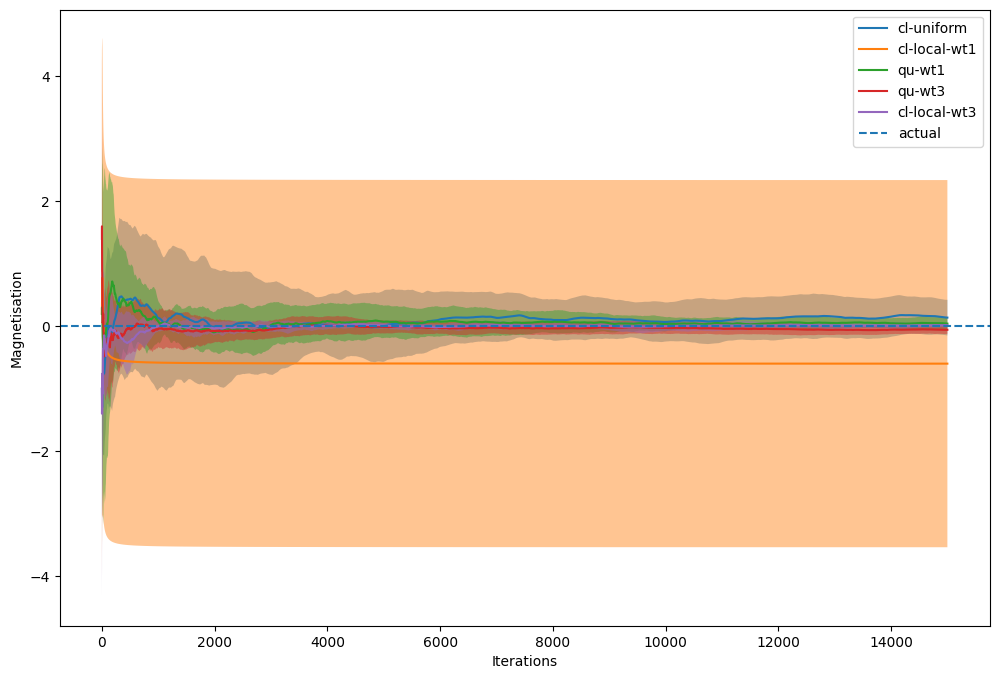

In [9]:
SAMPLINGRESULT_BAS3.PLOT_MAGNETISATION()

100%|██████████| 10/10 [00:01<00:00,  9.95it/s]


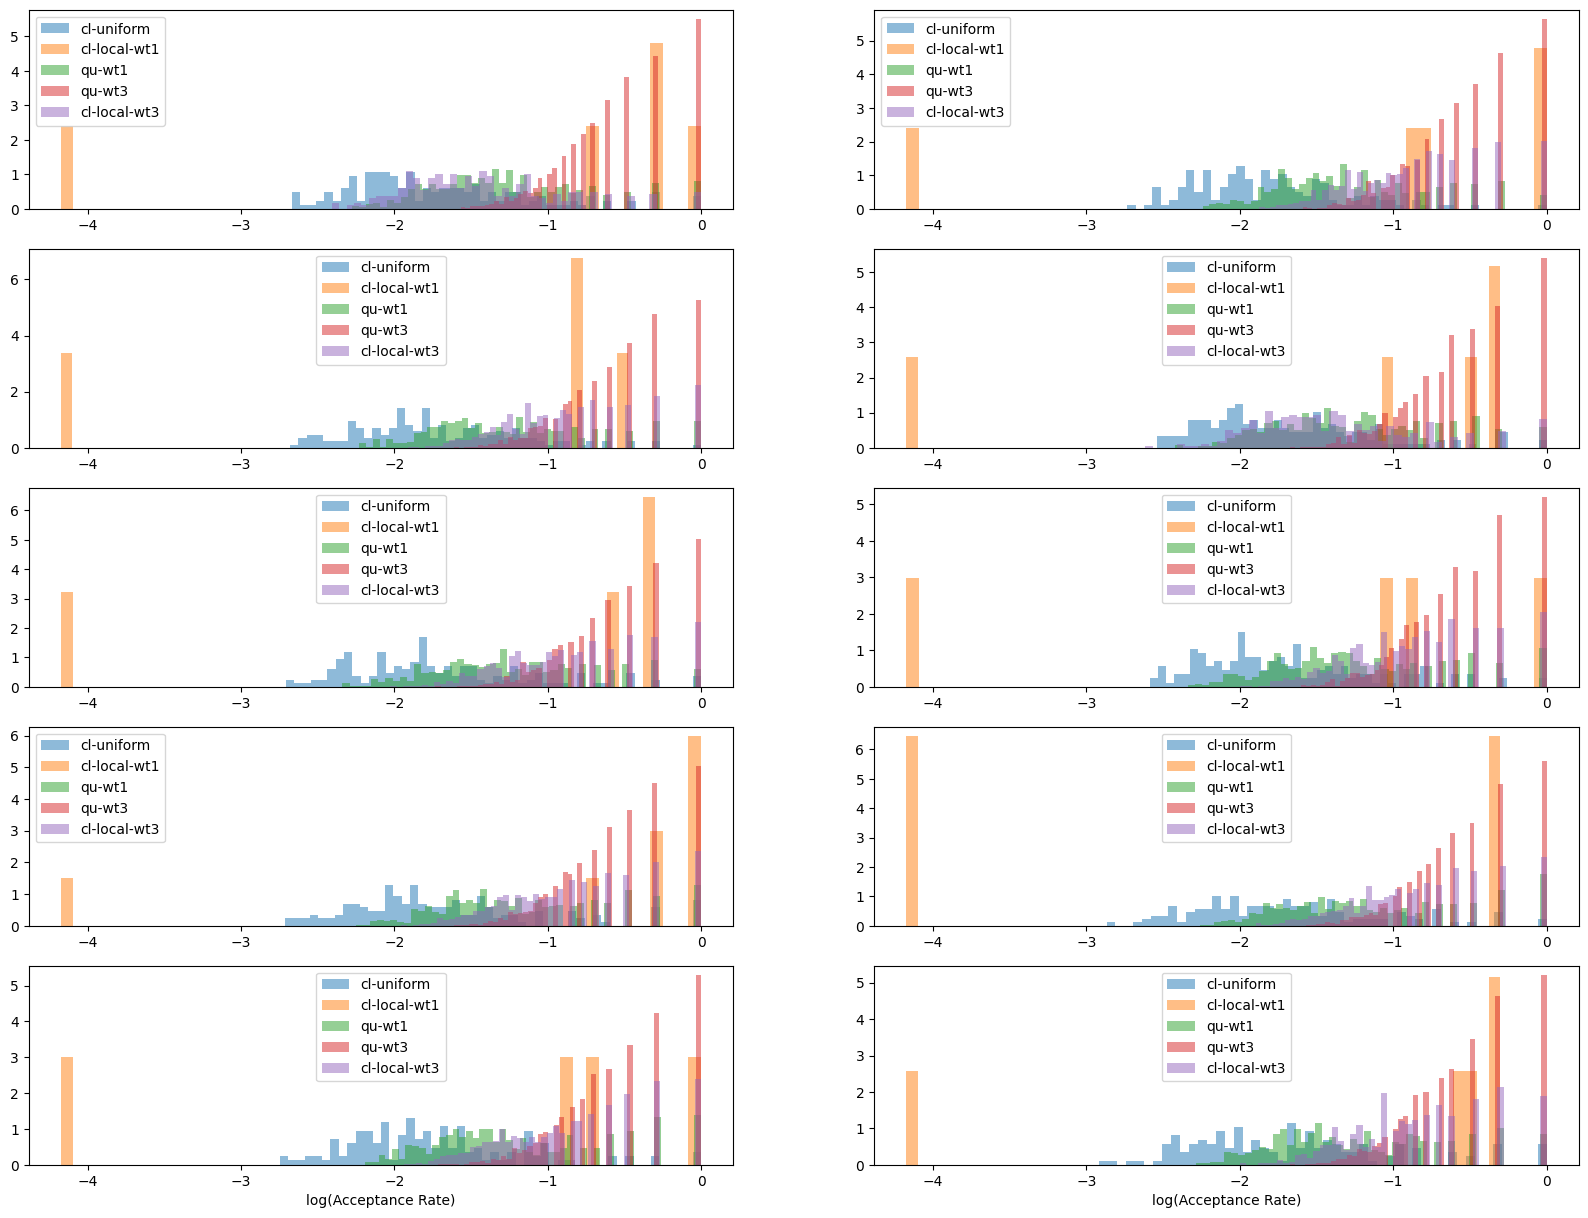

In [10]:
SAMPLINGRESULT_BAS3.PLOT_MCMC_STATISTICS()

100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


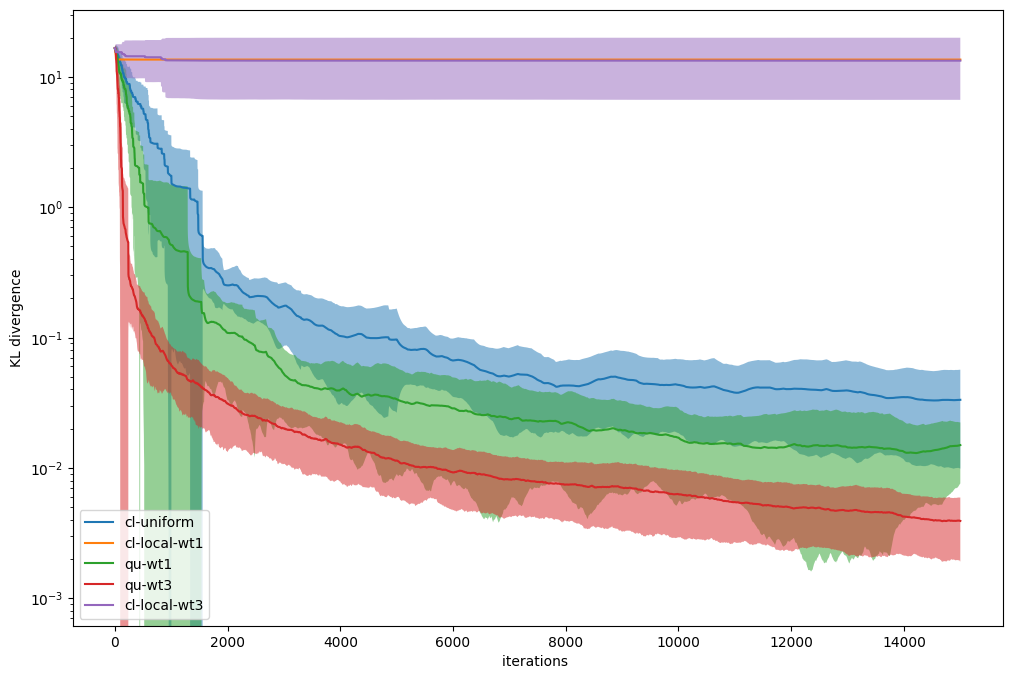

In [11]:
SAMPLINGRESULT_BAS3.PLOT_KL_DIV()

In [76]:
### HELPER FUNCTIONS ###
# def PLOT_MAGNETISATION(data: dict, model: Exact_Sampling ):

#   seeds = data.keys()
#   mcmc_types = data[1].keys()
#   simulation_data = { mcmc_type: [] for mcmc_type in mcmc_types }
#   magnetization_model = model.get_observable_expectation(magnetization_of_state)

#   for seed in tqdm(seeds):
#       for mcmc_type in mcmc_types:
#           mag = calculate_runnning_magnetisation(data[seed][mcmc_type], verbose= False)
#           simulation_data[mcmc_type].append(mag)

#   fig, ax1 = plt.subplots(figsize=(12,8))
  
#   left, bottom, width, height = [0.55, 0.2, 0.25, 0.25]

#   x=list(range(0,15000))

#   for mcmc_type in mcmc_types:
    
#     mean_mag_local=np.mean(simulation_data[mcmc_type],axis=0)
#     std_local=np.std(simulation_data[mcmc_type],axis=0)
#     ax1.plot(x,mean_mag_local,label= mcmc_type)
#     ax1.fill_between(x,mean_mag_local-std_local,mean_mag_local+std_local,alpha=0.45)


#   ax1.axhline(magnetization_model, label= 'actual',linestyle='--')
#   ax1.legend()
#   ax1.set_xlabel("Iterations")
#   ax1.set_ylabel("Magnetisation")

#   plt.show()

#   def PLOT_KL_DIV(data: dict, model: Exact_Sampling, return_data:bool= False ):

#     seeds = data.keys()
#     mcmc_types = data[1].keys()
#     simulation_data = { mcmc_type: [] for mcmc_type in mcmc_types }

#     for seed in tqdm(seeds):
#         for mcmc_type in mcmc_types:
#             kldiv = calculate_running_kl_divergence(model.boltzmann_pd, data[seed][mcmc_type])
#             simulation_data[mcmc_type].append(kldiv)

#     x=list(range(0,15000+1))
#     plt.figure(figsize=(12,8))
#     for mcmc_type in simulation_data.keys():
#       plot_with_error_band(x, simulation_data[mcmc_type] ,label= mcmc_type)
  
#     plt.xlabel("iterations ")
#     plt.ylabel("KL divergence")
#     plt.yscale('log')
#     plt.legend()
#     # plt.savefig("KL_BAS_3X3_bars_only.pdf")
#     # plt.savefig("KL_BAS_3X3_bars_only.jpeg")
#     plt.show()